In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import seaborn as sns

class Reaction:
    def __init__(self, reactions, fixed_concentrations=None) -> None:
        """
        Initialize the Reaction class with a list of reactions.
        
        Parameters:
        reactions (list): A list of reactions with associated rate constants.
        """
        self.reactions = reactions
        self.create_edges()
        self.G = nx.DiGraph()
        self.G.add_edges_from(self.edges)
        self.fixed_concentrations = fixed_concentrations or []

    def create_edges(self):
        """
        Creates edges representing the reactions between different substances. 
        It identifies the reactants and products and their respective rate constants for each reaction.
        """
        self.edges = []
        reaction_type_counter = 0

        for reaction in self.reactions:
            reaction_type_counter += 1
            reactants, products = reaction[0].split('<->') if '<->' in reaction[0] else reaction[0].split('->')
            rate_constants = reaction[1:]
            
            reactants = reactants.strip().split(' + ')
            products = products.strip().split(' + ')

            for reactant in reactants:
                for product in products:
                    self.edges.append((reactant.strip(), product.strip(), {'weight': rate_constants[0], 'type': f'k_{reaction_type_counter}'}))

            if '<->' in reaction[0] and len(rate_constants) > 1:
                reaction_type_counter += 1
                for reactant in reactants:
                    for product in products:
                        self.edges.append((product.strip(), reactant.strip(), {'weight': rate_constants[1], 'type': f'k_{reaction_type_counter}'}))


    def create_reaction_dict(self):
        """
        Creates a dictionary representing the reactions in the network.
        The dictionary groups substances based on the type of reactions they are involved in and calculates the rate constants for each grouped reaction.

        Returns:
        dict: A dictionary representing the grouped reactions and their rate constants.
        """
        self.reaction_dict = {}

        for node in self.G.nodes():
            in_edges = self.G.in_edges(node, data=True)
            out_edges = self.G.out_edges(node, data=True)

            type_groups = {}
            for u, v, data in in_edges:
                reaction_type = data['type']
                rate_constant = data['weight']

                if reaction_type not in type_groups:
                    type_groups[reaction_type] = {'nodes': set(), 'rate': rate_constant}
                type_groups[reaction_type]['nodes'].add(u)

            for u, v, data in out_edges:
                reaction_type = data['type']
                rate_constant = -data['weight']
                
                if reaction_type not in type_groups:
                    type_groups[reaction_type] = {'nodes': set(), 'rate': rate_constant}
                type_groups[reaction_type]['nodes'].add(node)

                neighbors_in_edges = self.G.in_edges(v, data=True)
                for nu, nv, ndata in neighbors_in_edges:
                    if ndata['type'] == reaction_type and nu != node:
                        type_groups[reaction_type]['nodes'].add(nu)
                
            self.reaction_dict[node] = [(tuple(group['nodes']), group['rate']) for group in type_groups.values()]

        return self.reaction_dict

    def rate_of_change(self, concs, t):
        """
        Calculate the rate of change of each substance at a given time point.

        Parameters:
        concs (list): List of current concentrations of the substances.
        t (float): Current time point.

        Returns:
        list: List of rate of changes of the substances.
        """
        conc_dict = {key: value for key, value in zip(self.sorted_keys, concs)}
        rate_dict = {key: 0 for key in self.sorted_keys}

        for substance, reactions_for_substance in self.reaction_dict.items():
            if substance in self.fixed_concentrations:
                rate_dict[substance] = 0
                continue

            for reaction in reactions_for_substance:
                rate = reaction[1]
                reactants = reaction[0]
                for reactant in reactants:
                    if reactant in conc_dict:
                        rate *= conc_dict[reactant]
                    else:
                        raise KeyError(f"Reactant {reactant} not found in the concentration dictionary")
                rate_dict[substance] += rate

        return [rate_dict[key] for key in self.sorted_keys]


    def solve(self, initial_concs_dict, time_points):
        # Getting sorted keys from the reaction dictionary
        if not hasattr(self, 'reaction_dict'):
            self.create_reaction_dict()
        if not hasattr(self, 'sorted_keys'):
            self.sorted_keys = sorted(self.reaction_dict.keys())

        # Preparing a list of initial concentrations in the same order as sorted keys
        initial_concs = [initial_concs_dict.get(key, 0) for key in self.sorted_keys]

        # Solving the differential equations
        solution = odeint(self.rate_of_change, initial_concs, time_points)

        # Creating a DataFrame from the solution
        df = pd.DataFrame(solution, columns=self.sorted_keys)
        df.index = time_points

        return df

        
    def plot_graph(self):
        """
        Plots a graphical representation of the reaction network using NetworkX and Matplotlib. 
        Displays the reactants, products, and the directions and rate constants of the reactions.
        """
        pos = nx.spring_layout(self.G)
        nx.draw_networkx(self.G, pos, with_labels=True, connectionstyle='arc3,rad=0.1', 
                         node_size=700, node_color='lightblue', font_size=10, font_color='black', 
                         edge_color='gray', width=2, alpha=0.6)

        # Display arrows indicating direction
        nx.draw_networkx_edge_labels(self.G, pos, 
                                     edge_labels={(u, v): f"{d['type']} ({d['weight']})" for u, v, d in self.G.edges(data=True)}, 
                                     label_pos=0.3)
        
        plt.show()


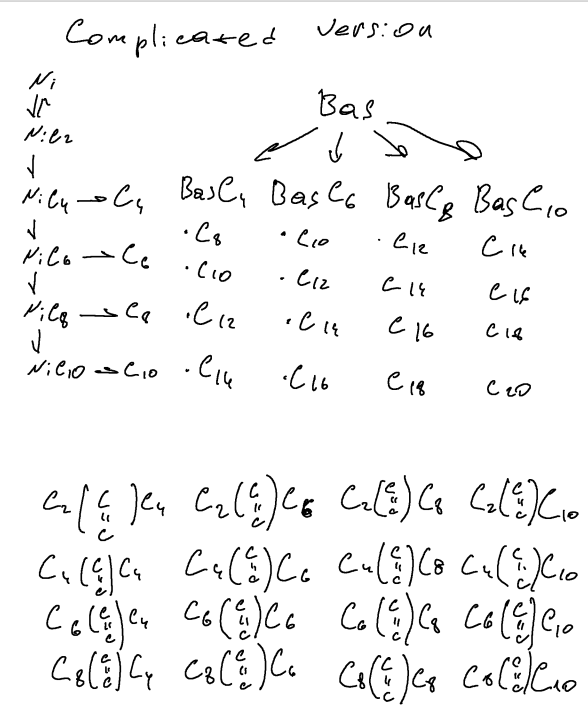

<Axes: >

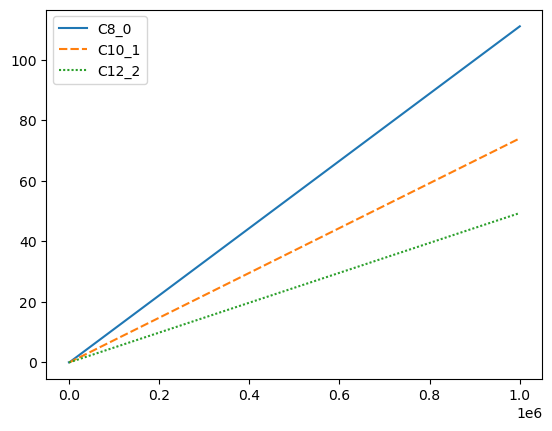

In [44]:

k_grow_ni = 1e-2
k_death_ni = 5e-3
k_grow_bas = 1e-3
k_death_bas = 1e-2


d0 = 1e-2
d1 = d0 * 0.5 
d2 = d1 * 0.5
d3 = d2 * 0.5
d4 = d3 * 0.5

reaction_list = [
                ['Ni + C2 <-> NiC2', k_grow_ni, k_grow_ni],
                ['NiC2 + C2 -> NiC4', k_grow_ni],['NiC4 -> C4 + Ni', k_death_ni],
                ['NiC4 + C2 -> NiC6', k_grow_ni],['NiC6 -> C6 + Ni', k_death_ni],
                ['NiC6 + C2 -> NiC8', k_grow_ni],['NiC8 -> C8 + Ni', k_death_ni],
                ['NiC8 + C2 -> NiC10', k_grow_ni],['NiC10 -> C10 + Ni', k_death_ni],
                 
                
                ['Bas + C4 -> BasC4_0', k_grow_bas],
                ['BasC4_0 + C4 -> BasC8_0', k_grow_bas],['BasC8_0 -> C8_0 + Bas', k_death_bas],
                ['BasC4_0 + C6 -> BasC10_0', k_grow_bas],['BasC10_0 -> C10_0 + Bas', k_death_bas],
                ['BasC4_0 + C8 -> BasC12_0', k_grow_bas],['BasC12_0 -> C12_0 + Bas', k_death_bas],
                ['BasC4_0 + C10 -> BasC14_0', k_grow_bas],['BasC14_0 -> C14_0 + Bas', k_death_bas],

                ['Bas + C6 -> BasC6_1', k_grow_bas],
                ['BasC6_1 + C4 -> BasC10_1', k_grow_bas],['BasC10_1 -> C10_1 + Bas', k_death_bas],
                ['BasC6_1 + C6 -> BasC12_1', k_grow_bas],['BasC12_1 -> C12_1 + Bas', k_death_bas],
                ['BasC6_1 + C8 -> BasC14_1', k_grow_bas],['BasC14_1 -> C14_1 + Bas', k_death_bas],
                ['BasC6_1 + C10 -> BasC16_1', k_grow_bas],['BasC16_1 -> C16_1 + Bas', k_death_bas],

                ['Bas + C8 -> BasC8_2', k_grow_bas],
                ['BasC8_2 + C4 -> BasC12_2', k_grow_bas],['BasC12_2 -> C12_2 + Bas', k_death_bas],
                ['BasC8_2 + C6 -> BasC14_2', k_grow_bas],['BasC14_2 -> C14_2 + Bas', k_death_bas],
                ['BasC8_2 + C8 -> BasC16_2', k_grow_bas],['BasC16_2 -> C16_2 + Bas', k_death_bas],
                ['BasC8_2 + C10 -> BasC18_2', k_grow_bas],['BasC18_2 -> C18_2 + Bas', k_death_bas],

                ['Bas + C10 -> BasC10_3', k_grow_bas],
                ['BasC10_3 + C4 -> BasC14_3', k_grow_bas],['BasC14_3 -> C14_3 + Bas', k_death_bas],
                ['BasC10_3 + C6 -> BasC16_3', k_grow_bas],['BasC16_3 -> C16_3 + Bas', k_death_bas],
                ['BasC10_3 + C8 -> BasC18_3', k_grow_bas],['BasC18_3 -> C18_3 + Bas', k_death_bas],
                ['BasC10_3 + C10 -> BasC20_3', k_grow_bas],['BasC20_3 -> C20_3 + Bas', k_death_bas],
                 ]

reaction = Reaction(reaction_list, fixed_concentrations=['C2'])
df = reaction.solve({'C2': 1, 'Ni': 1, 'Bas': 1}, np.linspace(0, 1000000, 1000_000))
sns.lineplot(df[['C8_0', 'C10_1', 'C12_2']])

In [45]:
df

,Bas,BasC10_0,BasC10_1,BasC10_3,BasC12_0,BasC12_1,BasC12_2,BasC14_0,BasC14_1,BasC14_2,...,C4,C6,C8,C8_0,Ni,NiC10,NiC2,NiC4,NiC6,NiC8
0.000000,1.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
1.000001,1.00,2.112812e-24,1.523032e-24,1.855116e-19,4.774931e-27,4.771331e-27,2.677699e-27,8.448791e-30,1.082533e-29,8.425400e-30,...,8.214129e-08,2.282324e-10,5.634504e-13,1.272164e-24,0.990099,1.125999e-12,0.009851,0.000049,1.636435e-07,4.548871e-10
2.000002,1.00,3.251085e-22,2.488285e-22,1.322990e-17,1.245067e-24,1.243487e-24,7.496676e-25,3.860550e-27,4.894859e-27,3.841802e-27,...,6.506291e-07,3.308130e-09,1.407915e-11,1.847477e-22,0.980394,2.812006e-11,0.019411,0.000194,1.291995e-06,6.576839e-09
3.000003,1.00,1.033376e-20,8.328835e-21,2.279794e-16,5.920379e-23,5.911112e-23,3.913279e-23,2.845086e-25,3.443356e-25,2.825595e-25,...,2.172787e-06,1.636332e-08,1.006050e-10,5.641580e-21,0.970880,2.007938e-10,0.028685,0.000430,4.299757e-06,3.244495e-08
4.000004,1.00,1.443766e-19,1.157161e-19,1.697342e-15,1.147655e-21,1.145225e-21,7.591265e-22,7.766134e-24,9.312079e-24,7.692034e-24,...,5.093304e-06,5.087537e-08,4.119856e-10,7.873391e-20,0.961553,8.216952e-10,0.037683,0.000754,1.004416e-05,1.005972e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995.999996,0.45,7.407407e-03,7.407407e-03,1.333333e-01,4.938272e-03,4.938272e-03,4.938272e-03,9.876543e-03,3.292181e-03,3.292181e-03,...,7.407407e-01,4.938272e-01,3.292181e-01,1.109667e+02,0.400000,1.185185e-01,0.200000,0.133333,8.888889e-02,5.925926e-02
999996.999997,0.45,7.407407e-03,7.407407e-03,1.333333e-01,4.938272e-03,4.938272e-03,4.938272e-03,9.876543e-03,3.292181e-03,3.292181e-03,...,7.407407e-01,4.938272e-01,3.292181e-01,1.109669e+02,0.400000,1.185185e-01,0.200000,0.133333,8.888889e-02,5.925926e-02
999997.999998,0.45,7.407407e-03,7.407407e-03,1.333333e-01,4.938272e-03,4.938272e-03,4.938272e-03,9.876543e-03,3.292181e-03,3.292181e-03,...,7.407407e-01,4.938272e-01,3.292181e-01,1.109670e+02,0.400000,1.185185e-01,0.200000,0.133333,8.888889e-02,5.925926e-02
999998.999999,0.45,7.407407e-03,7.407407e-03,1.333333e-01,4.938272e-03,4.938272e-03,4.938272e-03,9.876543e-03,3.292181e-03,3.292181e-03,...,7.407407e-01,4.938272e-01,3.292181e-01,1.109671e+02,0.400000,1.185185e-01,0.200000,0.133333,8.888889e-02,5.925926e-02
